In [1]:
import os
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

c:\Users\user\Miniconda3\envs\deepvit\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


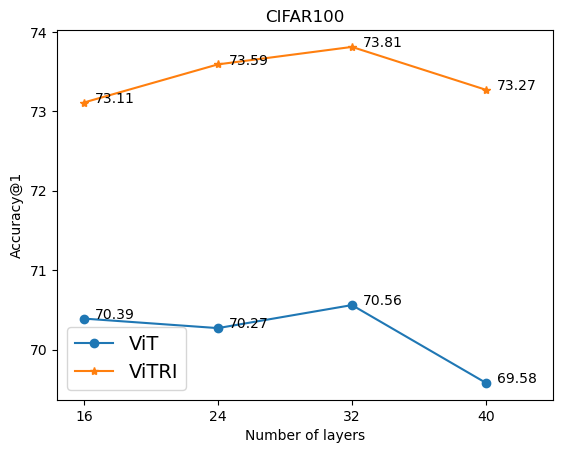

In [2]:
x = [1, 2, 3, 4]
vit = [70.390, 70.270, 70.560, 69.580]
vitri = [73.110, 73.590, 73.810, 73.270]

plt.xticks(x, ['16', '24', '32', '40'])

for x_c, y_c in zip(x, vit):
    plt.annotate(y_c, xy=(x_c + 0.08, y_c))

for x_c, y_c in zip(x, vitri):
    plt.annotate(y_c, xy=(x_c + 0.08, y_c))

plt.xlim(0.8, 4.5)
plt.title('CIFAR100')
plt.plot(x, vit, marker='o', label='ViT')
plt.plot(x, vitri, marker='*', label='ViTRI')
plt.xlabel('Number of layers')
plt.ylabel('Accuracy@1')
plt.legend(fontsize=14)
plt.show()

In [3]:
def _get_cache_path(dataset_name: str, mode: str, data_path):
    import hashlib

    seed = dataset_name + mode

    h = hashlib.sha1(seed.encode()).hexdigest()
    cache_path = os.path.join(data_path, 'cache', f"{mode}_{h[:10]}.pt")
    cache_path = os.path.expanduser(cache_path)
    return cache_path

dataset_name = 'cifar'  # 'cifar', 'imagenet'
dataset_path = './dataset/CIFAR100' # './dataset/CIFAR100', './dataset/ImageNet'
cache_path = _get_cache_path(dataset_name, 'train', dataset_path)
cache_path_test = _get_cache_path(dataset_name, 'val', dataset_path)

In [4]:
dataset = torch.load(cache_path)
dataset_test = torch.load(cache_path_test)

train_sampler = torch.utils.data.RandomSampler(dataset)
test_sampler = torch.utils.data.SequentialSampler(dataset_test)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=train_sampler)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, sampler=test_sampler)

In [5]:
train_crop_size = 224
device = 'cuda'

In [6]:
from models.configs import CONFIGS
from models.vitri import ViTRI
from models.vit import VisionTransformer

num_classes = len(dataset.classes)

layer_num = 40
model_name = f"ViT-B_{layer_num}"
config = CONFIGS[model_name]

model_ri = ViTRI(config, train_crop_size, zero_head=True, num_classes=num_classes)
model_origin = VisionTransformer(config, train_crop_size, zero_head=True, num_classes=num_classes)

checkout_path_ri = f'./output/cifar100/ViTRI_{layer_num}/model_.pth'
checkout_path_origin = f'./output/cifar100/ViT_{layer_num}/model_.pth'

checkout_ri = torch.load(checkout_path_ri)
checkout_origin = torch.load(checkout_path_origin)

In [7]:
model_ri.load_state_dict(checkout_ri['model'])
model_origin.load_state_dict(checkout_origin['model'])

<All keys matched successfully>

In [8]:
loader = iter(data_loader_test)

In [9]:
def conver_to_numpy(x_list):
    ret_list = []
    for x in x_list:
        ret_list.append(x.squeeze().detach().cpu().numpy())
    return np.array(ret_list)


def save_result(model, img, feature_list, attention_list):
    _, _, fe, attn = model(img)
    feature_list.append(conver_to_numpy(fe))
    attention_list.append(conver_to_numpy(attn))

In [10]:
fe_list_ri = []
attn_list_ri = []

fe_list_origin = []
attn_list_origin = []

data_num = 100

for _ in tqdm(range(data_num)):
    img, label = next(loader)
    save_result(model_ri, img, fe_list_ri, attn_list_ri)
    save_result(model_origin, img, fe_list_origin, attn_list_origin)

100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


In [11]:
fe_list_ri = np.array(fe_list_ri)
attn_list_ri = np.array(attn_list_ri)

fe_list_origin = np.array(fe_list_origin)
attn_list_origin = np.array(attn_list_origin)

In [12]:
def cos_sim_feature(fe, last=None):
    if last is None: output = cosine_similarity(fe)
    else: output = cosine_similarity(fe, last)

    n = output.shape[0]
    sim = 0
    for i in range(n):
        for j in range(i+1, n):
            sim += abs(output[i][j])
    
    ret = sim * 2 / (n - 1) / (n)
    
    return ret

In [13]:
def mean_sim(fe_lists):
    sim_list_all = []
    for fe_list in tqdm(fe_lists):
        sim_list = []
        for fe in fe_list: 
            sim_list.append(cos_sim_feature(fe))
        sim_list_all.append(sim_list)
    
    sim_list_all = np.array(sim_list_all)
    return sim_list_all.mean(axis=0)

In [14]:
mean_sim_ri = mean_sim(fe_list_ri)
mean_sim_origin = mean_sim(fe_list_origin)

100%|██████████| 100/100 [00:27<00:00,  3.63it/s]


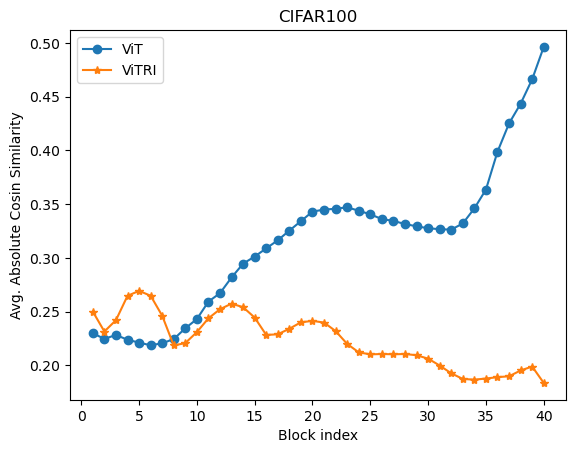

In [15]:
x = list(range(1, layer_num+1))
plt.plot(x, mean_sim_origin, label='ViT', marker='o')
plt.plot(x, mean_sim_ri, label='ViTRI', marker='*')
plt.title('CIFAR100')
plt.xlabel('Block index')
plt.ylabel('Avg. Absolute Cosin Similarity')
plt.legend()

In [16]:
mean_attn_list_ri = attn_list_ri.mean(axis=0).mean(axis=1)
mean_attn_list_origin = attn_list_origin.mean(axis=0).mean(axis=1)

In [17]:
def vis_attn(layer, attn_map, prob):
    data_np = attn_map[layer]
    seed = (data_np.max() - data_np.min())
    sns.heatmap(data_np, cmap='Blues', vmin=data_np.min(), vmax=data_np.max() - (seed * prob), cbar=False)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [18]:
layer_index = 7
prob = 0.3

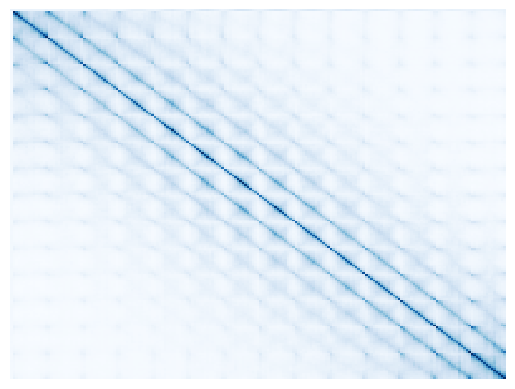

In [19]:
vis_attn(layer_index, mean_attn_list_origin, prob)

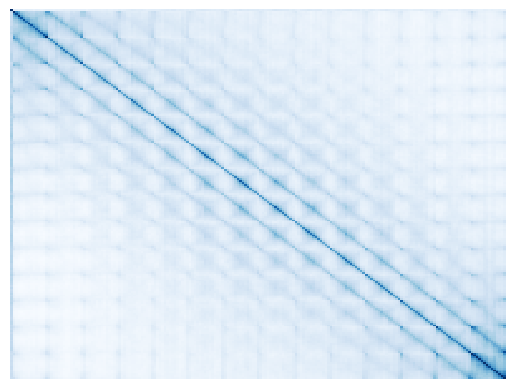

In [20]:
vis_attn(layer_index, mean_attn_list_ri, prob=0.8)

In [21]:
layer_index = 15

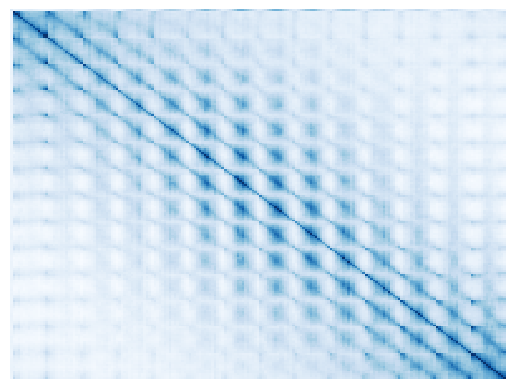

In [22]:
vis_attn(layer_index, mean_attn_list_origin, prob)

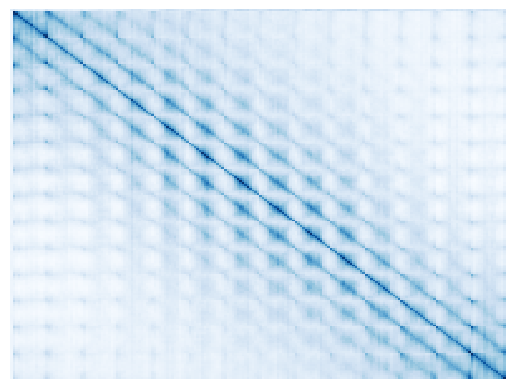

In [23]:
vis_attn(layer_index, mean_attn_list_ri, prob)

In [24]:
layer_index = 23

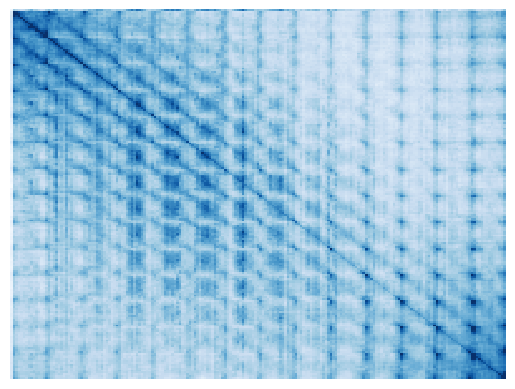

In [25]:
vis_attn(layer_index, mean_attn_list_origin, prob)

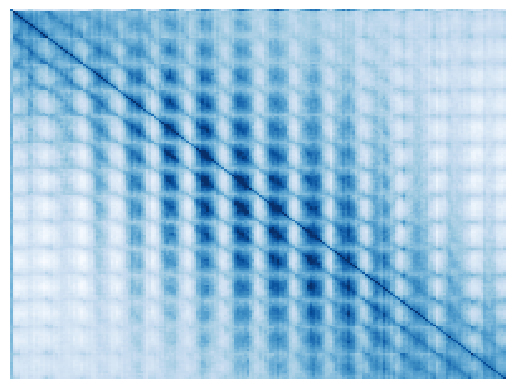

In [26]:
vis_attn(layer_index, mean_attn_list_ri, prob)

In [27]:
layer_index = 31

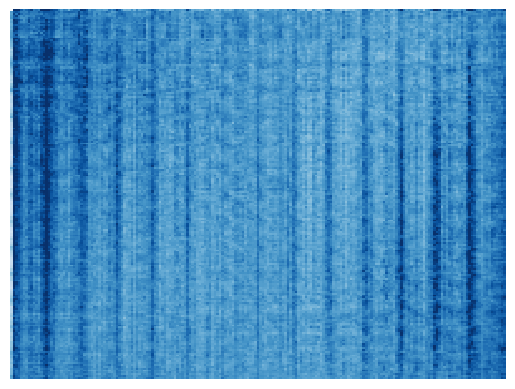

In [28]:
vis_attn(layer_index, mean_attn_list_origin, prob)

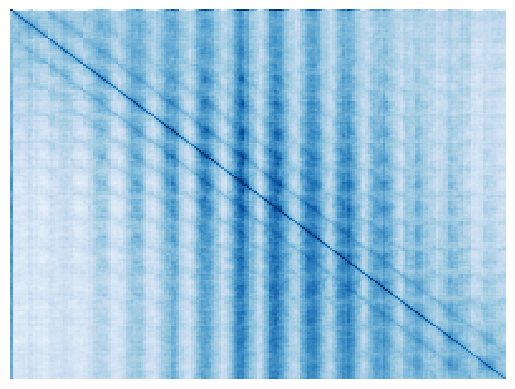

In [29]:
vis_attn(layer_index, mean_attn_list_ri, prob)

In [30]:
layer_index = 39

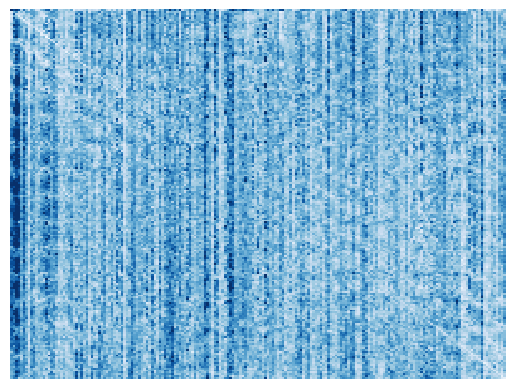

In [31]:
vis_attn(layer_index, mean_attn_list_origin, prob)

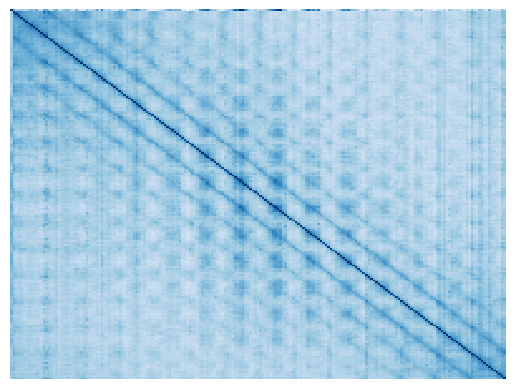

In [32]:
vis_attn(layer_index, mean_attn_list_ri, prob)